In [1]:
import torch
import numpy as np
from training import train
from data_utils import make_dataset, load_dataset, fit_dset_to_m, make_grid_dataset
from controls import LQR
from tasks import stabilize_cartpole
from plotting import plot_trajectories, plot_experiment_new
from models import save_model, load_model
from experiments import run_experiment, save_experiment, load_experiment
import params
from IPython.display import HTML
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

######################
### DISPLAY CONFIG ###
######################
for name, values in vars(params).items():
    print(name, values)

torch.set_default_device("cuda")
#torch.set_default_device("cpu")

%load_ext autoreload
%autoreload 2

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__name__ params
__doc__ None
__package__ 
__loader__ <_frozen_importlib_external.SourceFileLoader object at 0x7fa54fd40cb0>
__spec__ ModuleSpec(name='params', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7fa54fd40cb0>, origin='/home1/lutkus/latent_space/cartpole_lyapunov/params.py')
__file__ /home1/lutkus/latent_space/cartpole_lyapunov/params.py
__cached__ /home1/lutkus/latent_space/cartpole_lyapunov/__pycache__/params.cpython-313.pyc
__builtins__ {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.", '__package__': '', '__loader__': <class '_frozen_impor

In [2]:
#data = make_dataset(save=True, fname=params.dataset, render_mode=None, expert_controller=False)
#data = make_grid_dataset([0.5, 0.5, 0.5, 0.5], [3], 10)
data = make_grid_dataset(params.grid_x_ranges, params.grid_u_ranges, params.grid_n_per_axis)
#data = load_dataset(fname=params.dataset)
X, U, Xtest, Utest = data
'''
data_rand = load_dataset(fname=params.dataset2)
X0, U0 = fit_dset_to_m(X[0], U[0])
X = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))
U = (torch.vstack([U0,data_rand[1][0]]), None)
Xtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])
Xtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))
Utest = (torch.vstack([Utest0,data_rand[3][0]]), None)
print("DSET SIZES:")
print(X[0].shape)
print(X[1].shape)
'''

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 31%|███       | 978047/3200000 [1:16:19<1:48:12, 342.24it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 3200000/3200000 [4:11:28<00:00, 212.08it/s]   


X shape torch.Size([3200000, 16, 4])
U shape torch.Size([3200000, 15, 1])


  6%|▌         | 3174355/51200000 [08:24<1:56:32, 6868.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 51200000/51200000 [2:07:02<00:00, 6717.24it/s]  
/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/utils/_device.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return func(*args, **kwargs)


X_drift shape torch.Size([51200000, 2, 4])
saving to:  /home1/lutkus/latent_space/cartpole_lyapunov/data/grid_dset_T16_expanded.pkl
dataset saved


'\ndata_rand = load_dataset(fname=params.dataset2)\nX0, U0 = fit_dset_to_m(X[0], U[0])\nX = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))\nU = (torch.vstack([U0,data_rand[1][0]]), None)\nXtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])\nXtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))\nUtest = (torch.vstack([Utest0,data_rand[3][0]]), None)\nprint("DSET SIZES:")\nprint(X[0].shape)\nprint(X[1].shape)\n'

15
original state:
 [(0, 1, 3), (2,)]
n_combinations 4
n_params 2
{'ae': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), 

  1%|          | 1/100 [01:05<1:47:30, 65.16s/it]

ep 0: train 1.3450068235397339    test nan
rec 0.5313089489936829    mstep 0.8136997818946838    jac 0.0
horizon is now 2


 39%|███▉      | 39/100 [39:36<1:01:57, 60.94s/it]

horizon is now 3


100%|██████████| 100/100 [1:55:23<00:00, 69.24s/it]

ep 99: train 1.7795791625976562    test nan
rec 0.4310951232910156    mstep 1.3484834432601929    jac 0.0


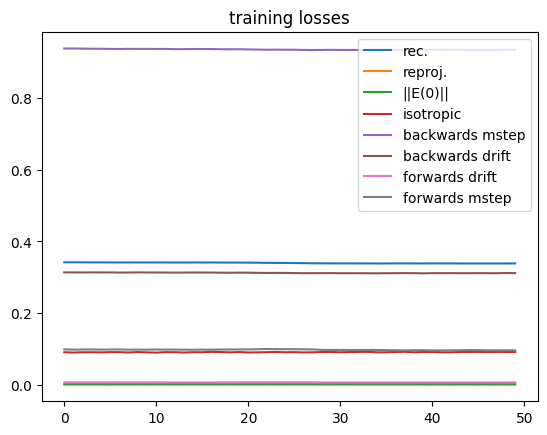

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is <function uniform_ at 0x7fa550d37060>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is <function uniform_ at 0x7fa550d37060>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is <function zeros_ at 0x7fa550d37420>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa

  1%|          | 1/100 [01:06<1:49:03, 66.10s/it]

ep 0: train 1.0701136589050293    test nan
rec 0.4195747971534729    mstep 0.6505396366119385    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [02:07<1:43:14, 63.20s/it]

0.8140751
it: 2; avg reward: 3756.1757689761757; completion rate: 0.0891089108910891; gamma_max: 0.8140751123428345
horizon is now 3


100%|██████████| 100/100 [1:59:41<00:00, 71.81s/it] 

ep 99: train 1.6362630128860474    test nan
rec 0.39289799332618713    mstep 1.2433650493621826    jac 0.0


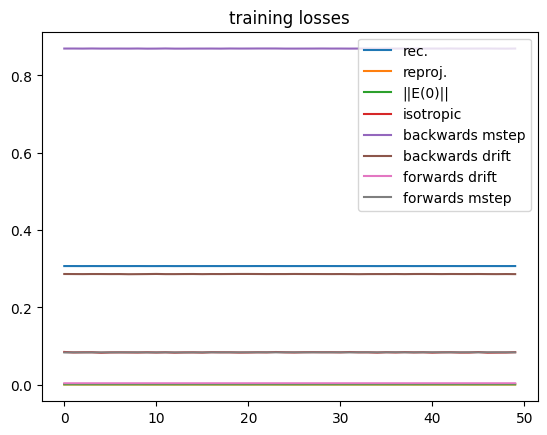

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is <function uniform_ at 0x7fa550d37060>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is <function uniform_ at 0x7fa550d37060>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa550d376a0>
g bias init is <function zeros_ at 0x7fa550d37420>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7fa

  1%|          | 1/100 [01:02<1:42:27, 62.10s/it]

ep 0: train 0.5828920006752014    test nan
rec 0.28965961933135986    mstep 0.29323244094848633    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [01:58<1:36:05, 58.83s/it]

0.43875605
it: 2; avg reward: 3059.65058767333; completion rate: 0.68; gamma_max: 0.4387560486793518
horizon is now 3


  3%|▎         | 3/100 [03:13<1:47:00, 66.20s/it]

horizon is now 4


  4%|▍         | 4/100 [04:33<1:54:16, 71.42s/it]

0.19914553
it: 4; avg reward: 2540.841649628043; completion rate: 0.91; gamma_max: 0.19914552569389343
horizon is now 5


  5%|▌         | 5/100 [06:11<2:08:42, 81.28s/it]

horizon is now 6


  6%|▌         | 6/100 [07:54<2:18:36, 88.48s/it]

0.1571683
it: 6; avg reward: 1516.1777110271544; completion rate: 0.76; gamma_max: 0.15716829895973206
horizon is now 7


  7%|▋         | 7/100 [09:55<2:33:39, 99.13s/it]

horizon is now 8


  9%|▉         | 9/100 [14:06<2:51:47, 113.27s/it]

horizon is now 9


 10%|█         | 10/100 [16:24<3:01:17, 120.86s/it]

In [ ]:
from experiments import run_experiment_new
#spec = {'m':[3, 4, 5], 'rec_jac':[True, False, True], 'ptb_eps_x':[1e-9, 1e-6, 1e-3]}

'''
spec = {"predict_mstep" : [True, False, True], 
        "penalize_rec" : [True, True, True], 
        "penalize_reproj" : [False, True, True],
        "penalize_encoder_diagram_mstep" : [False, True, True]}
'''
name = 'fwd_penalty_exp_3'
'''
spec = {'m':[7, 8, 9],
        'm_schedule':[7*[0], 8*[0], 9*[0]]}
'''
spec = {'symbols': [(0,1,2,3), (0, 1, 3), (1, 2, 3), (1, 3)],
        'ignored': [(), (2,), (0,), (0, 2)]}
#n_runs = len(list(spec.items())[0][1])*[1]
n_runs = [1, 1, 1, 0]
print(params.m)
exp=run_experiment_new(data, spec, plot=True, n_runs=n_runs, fname=name, save=True)
print(params.m)


In [26]:
#######################
### Save Experiment ###
#######################

#save_name = 'nontrivial_3'
#save_name = 'BASELINE'
#save_experiment(save_name, exp)

saving BASELINE.pkl


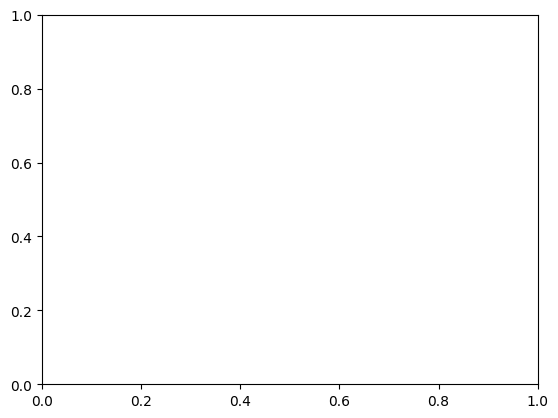

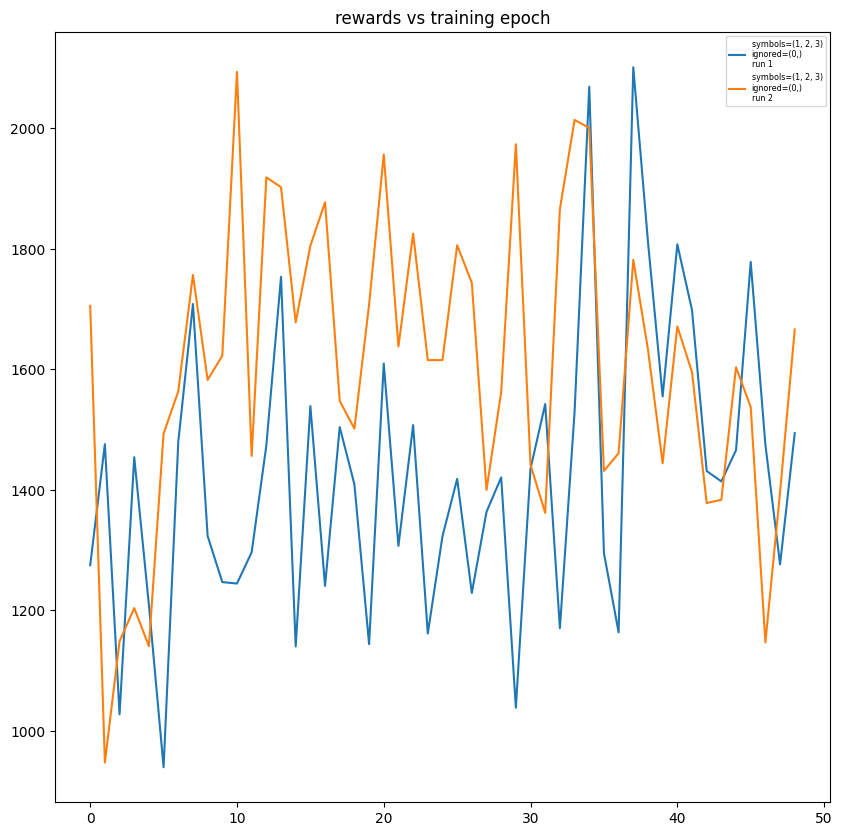

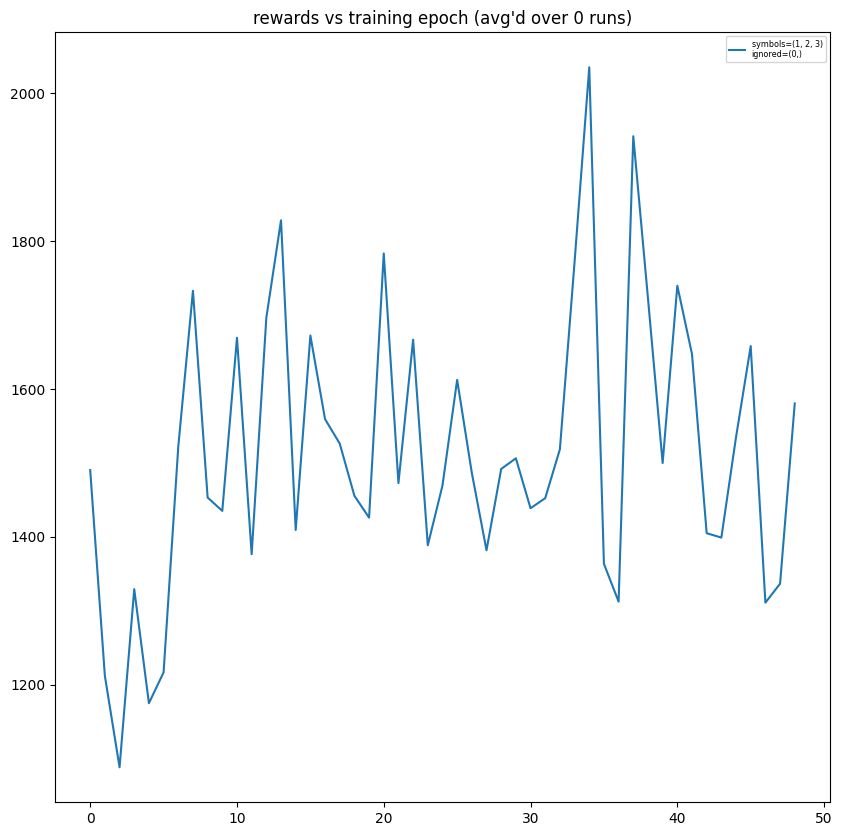

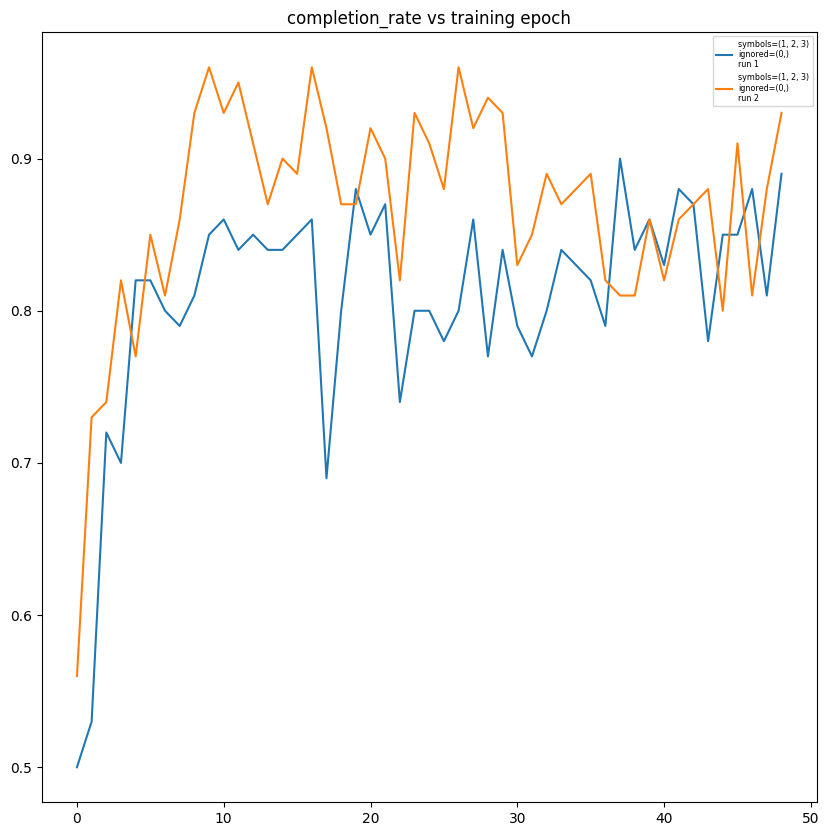

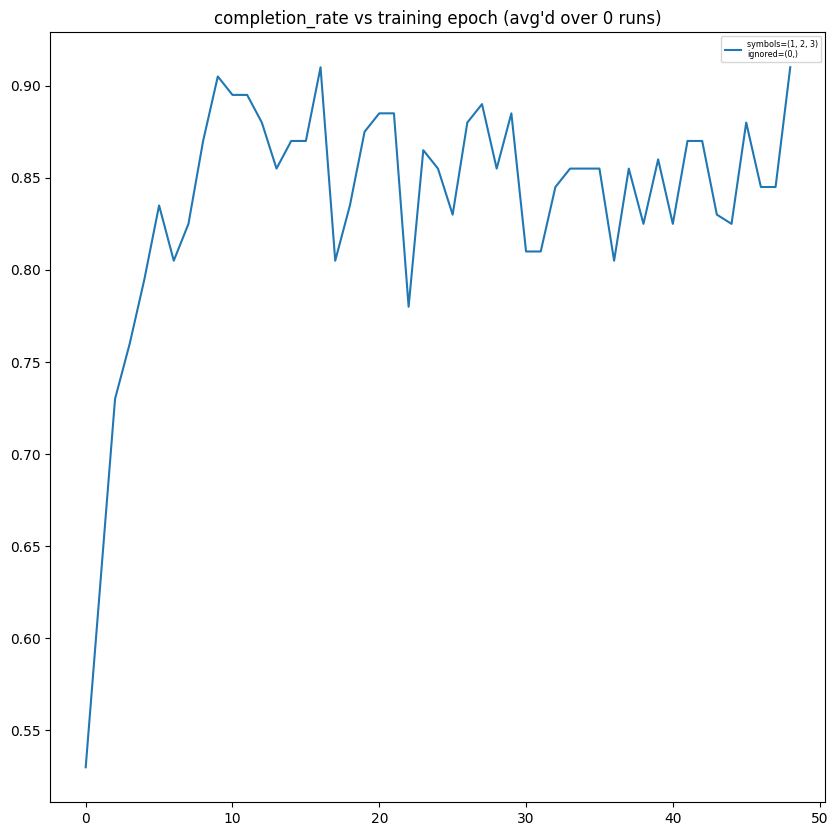

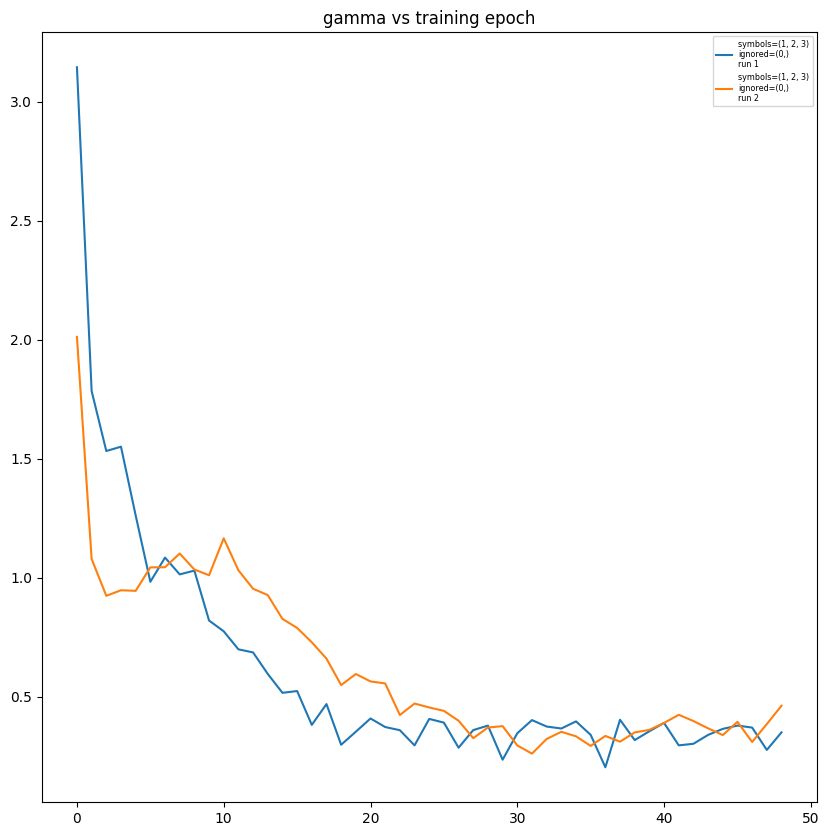

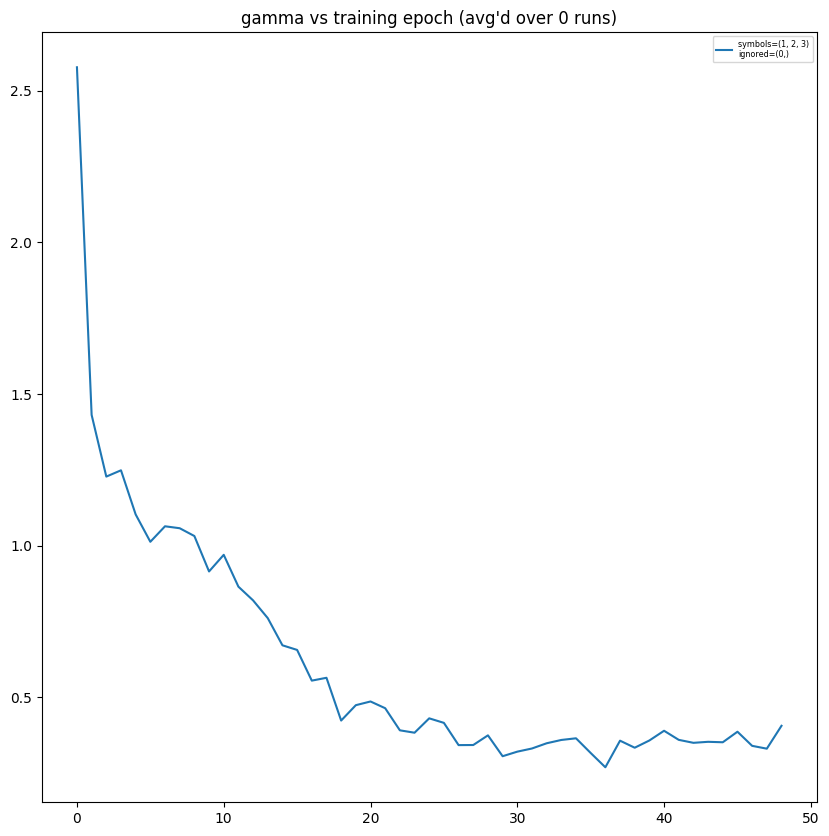

In [3]:
#######################
### Load Experiment ###
#######################

#name = "test_exp"
#name = "backwards-both_runs"
#name = 'both_runs'
#name = "small_pert"
#name = "extra_small_pert"
#name = "xxs_pert_exp"
#name = 'm-ablation'
#name = 'symbol-ablation-default_dataset'
#name = 'symbol-ablation-default_dataset_2'
#name = 'nontrivial_2'
#name = 'fwd_penalty_exp'
#name = 'fwd_penalty_exp_2'
#name = 'nontrivial_3'
#name = 'fwd_penalty_exp_3'
name = 'BASELINE'
exp = load_experiment(name)
plot_experiment_new(exp)

In [5]:
config_idx = 2#2
run_idx = 0#1
#best_model_idx = np.argmax(exp['completion_rate'][config_idx][1][run_idx])
#best_model_idx = np.argmin(exp['gamma'][config_idx][1][run_idx])
#best_model_idx = 79 #-2
best_model_idx = -1
print(best_model_idx)
ae = exp['ae_list'][config_idx][1][run_idx][best_model_idx]
fdyn = exp['fdyn_list'][config_idx][1][run_idx][best_model_idx]
ae.encode(torch.tensor([0.,0.,0.,0.]))

-1


tensor([0.0007, 0.0012], device='cuda:0', grad_fn=<ViewBackward0>)

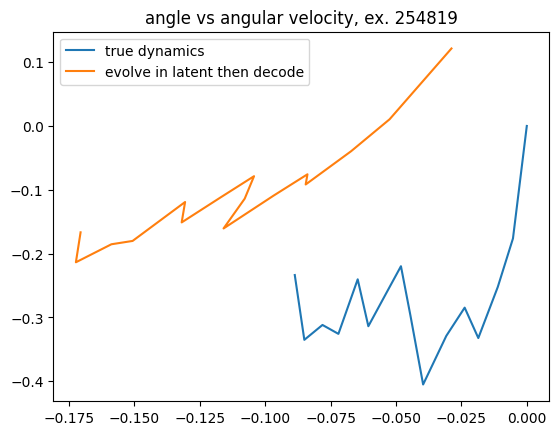

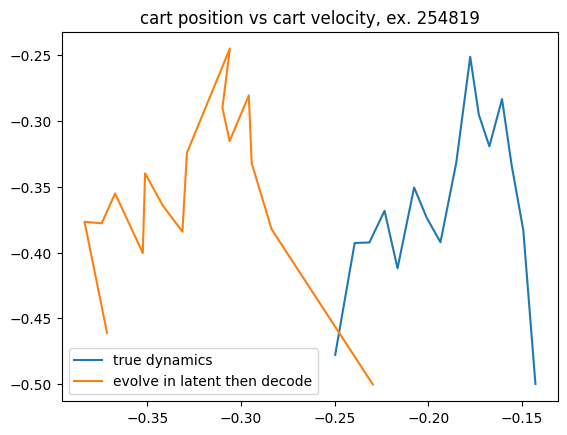

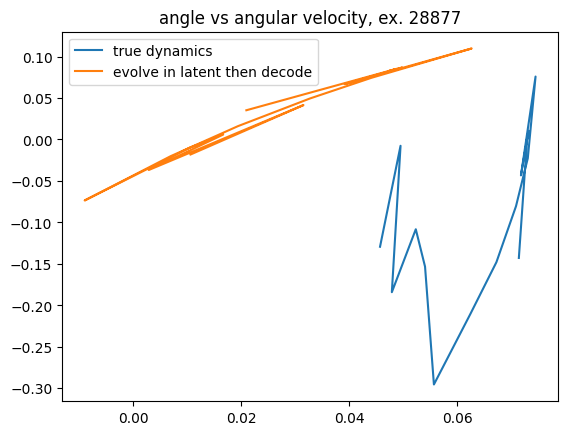

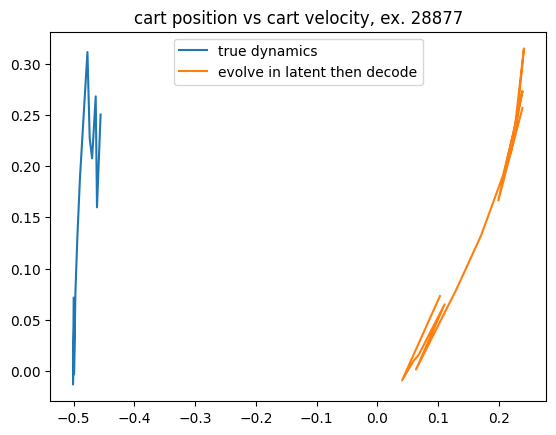

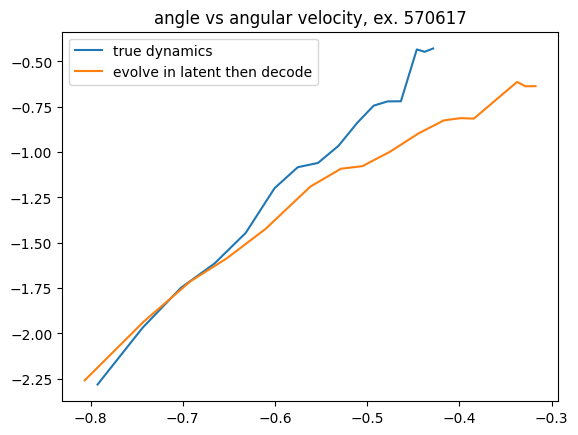

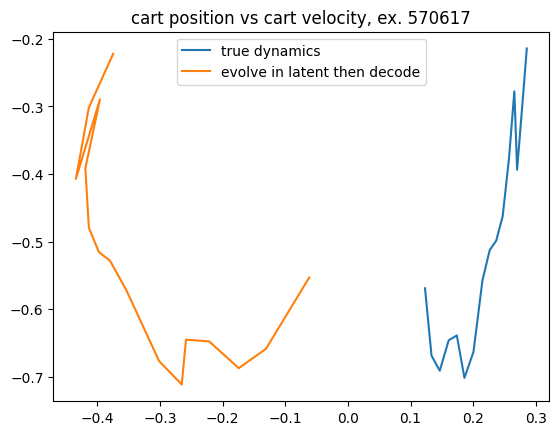

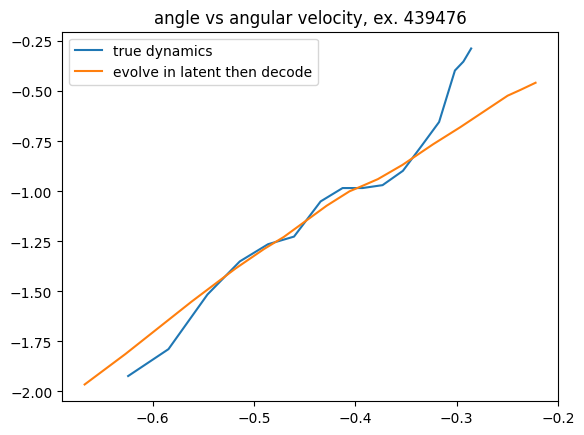

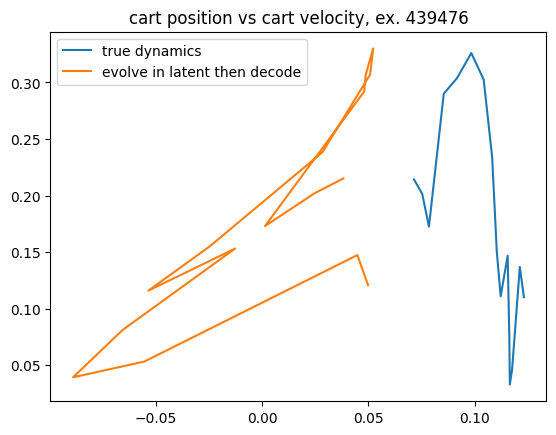

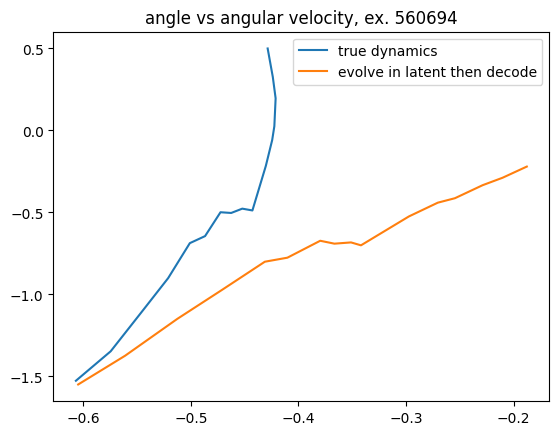

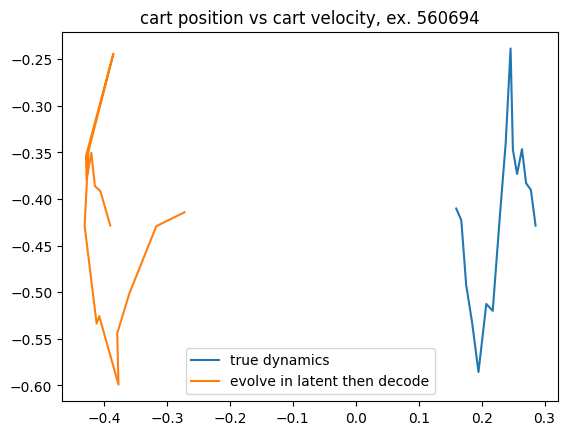

In [6]:
#########################
### Plot Trajectories ###
#########################

plot_trajectories(ae, fdyn, Xtest[0], Utest[0], 5, steps=params.traj_len)#params.m+1)

In [ ]:
######################
### Plot Stability ###
######################

from plotting import plot_stability
n_pts = 5000
eps = np.pi/6 #np.pi/3 
T = 500
tol = np.pi/2
low = [0+-eps, -eps, -eps, -eps]
high = [0+eps, eps, eps, eps]
plot_stability(ae, fdyn, n_pts, low, high, tol, T, visualize=False, latent_traj=True)

In [ ]:
##############################################
### Plot Inverse Image of Latent Norm Ball ###
##############################################

from plotting import plot_preimage_norm_ball

n = 10000
i = 1
j = 2
ivals = [0.]
jvals = [0.]
for ival in ivals:
    for jval in jvals:
        plot_preimage_norm_ball(ae, 0.25, i=i, ival=ival, j=j, jval=jval, n=n) #0.25

<unknown>:220: SyntaxWarning: invalid escape sequence '\c'
<unknown>:270: SyntaxWarning: invalid escape sequence '\p'
<unknown>:281: SyntaxWarning: invalid escape sequence '\c'
<unknown>:220: SyntaxWarning: invalid escape sequence '\c'
<unknown>:270: SyntaxWarning: invalid escape sequence '\p'
<unknown>:281: SyntaxWarning: invalid escape sequence '\c'


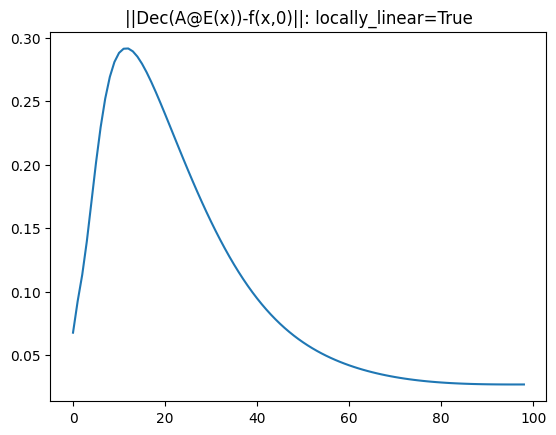

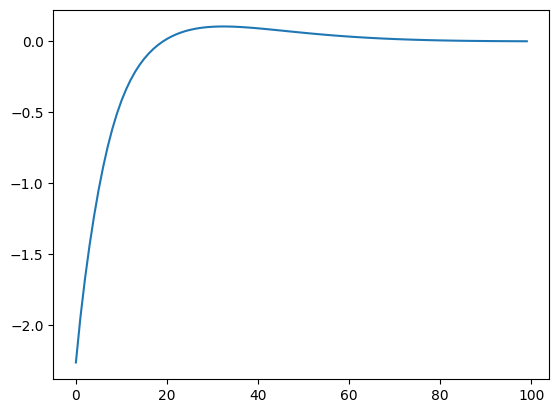

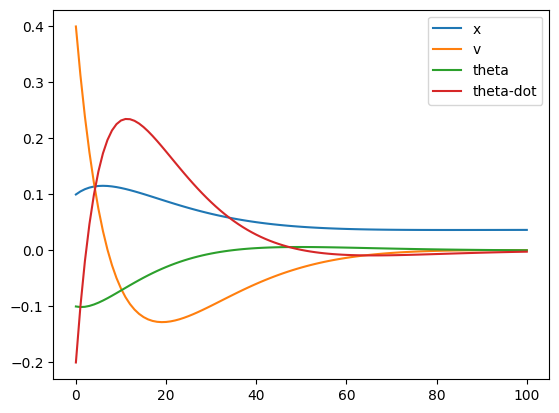

[0.0, 0.1]
[0.0, 0.4]
[-0.1, 0.0]
[-0.2, 0.0]
(array([ 0.        ,  0.01111111,  0.02222222,  0.03333333,  0.04444444,
        0.05555556,  0.06666667,  0.07777778,  0.08888889,  0.1       ,
        0.        ,  0.04444444,  0.08888889,  0.13333333,  0.17777778,
        0.22222222,  0.26666667,  0.31111111,  0.35555556,  0.4       ,
       -0.1       , -0.08888889, -0.07777778, -0.06666667, -0.05555556,
       -0.04444444, -0.03333333, -0.02222222, -0.01111111,  0.        ,
       -0.2       , -0.17777778, -0.15555556, -0.13333333, -0.11111111,
       -0.08888889, -0.06666667, -0.04444444, -0.02222222,  0.        ]),)
(10, 4)


100%|██████████| 10/10 [00:00<00:00, 29.20it/s]


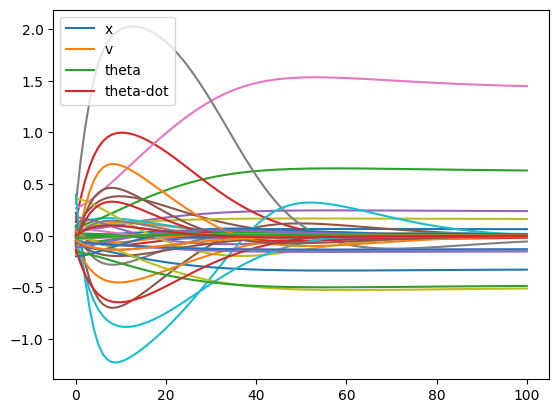

In [63]:
########################
### Stabilize System ###
########################

from controls import LQR
from theorem_tools import verify_invariance

lqr = LQR(ae, fdyn)
_ = stabilize_cartpole(lqr, ae, T=1, tmax=100, stabilize=True, eps=0.25, visualize=False)
'''
ranges = [[ 0. , 0.1], 
          [ 0. , 0.4], 
          [-0.1, 0. ], 
          [-0.20,0. ]]
'''
ranges = [[ 0. , 0.1], 
          [ 0. , 0.4], 
          [-0.1, 0. ], 
          [-0.2, 0. ]]
_ = verify_invariance(lqr, ae, ranges, T=100, stabilize=True, n_per_axis=10)

z_eq tensor([[0.0007, 0.0012]], device='cuda:0', grad_fn=<AddmmBackward0>)


100%|██████████| 750/750 [01:22<00:00,  9.12it/s]


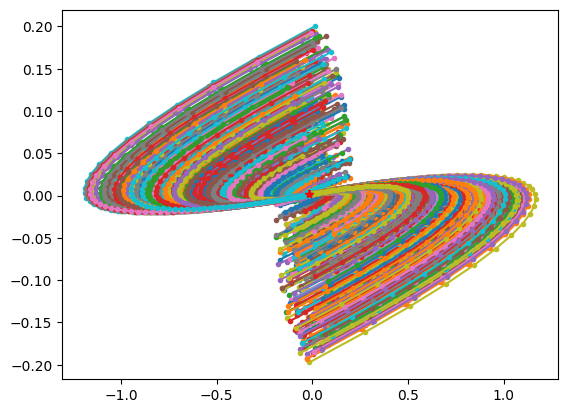

100%|██████████| 750/750 [01:16<00:00,  9.80it/s]


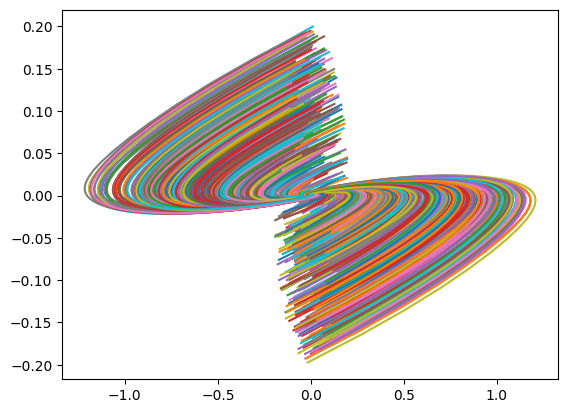

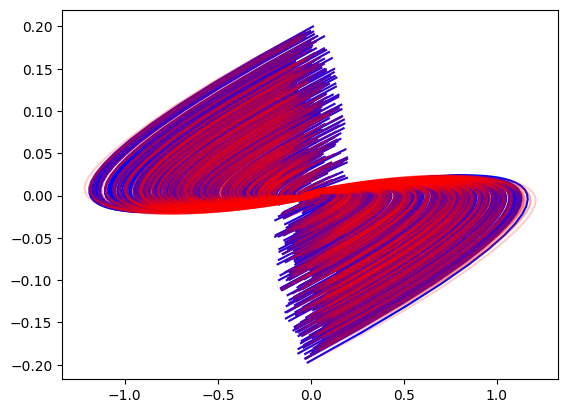

x data (750, 301, 4)
z data (750, 301, 2)
z proj data (750, 301, 2)
u data (750, 300, 1)
gamma forward 0.003532008
gamma backward 0.57498765


In [67]:
####################################
### Initialize Data for Lyapunov ###
####################################

from plotting import plot_latent_trajectories
from utils import rollout_trajectories

r = 1.2e-1#2e-3 #1e-3
r_test = r #1e-3 #5e-3
rz_init = 0.2 # BEST 0.2 0.2 #0.1 #0.02 #0.080 #0.005
#rx_init = rz_init
#rz_proj_init = 0.06
n_traj = 750 #500 #3000 #250 350 1000
T = 300
b = ae.encode(torch.tensor(4*[0.,])).cpu().detach().numpy()


for u_cost in [1]:
    lqr = LQR(ae, fdyn, u_cost=u_cost)
    pts, z_data, x_init_cond = plot_latent_trajectories(ae, fdyn, rz_init, n_traj, T=T, plot_quadratic=False, origin_spec=(b, r), lqr=lqr) #r=0.05
    x_data, z_proj_data, u_data, gammas = rollout_trajectories (ae, fdyn, lqr, x_init_cond, plot=True, n_traj=n_traj, T=T)
    gamma_fwd, gamma_bwd = gammas
    
    for zi in z_data:
        plt.plot(zi[:,0], zi[:,1], 'b-')
    for zi in z_proj_data:
        plt.plot(zi[:,0], zi[:,1], 'r-', alpha=0.2)
    plt.show()
    
    u_data = u_data[...,np.newaxis]
    
    #print(pts.shape)
    print("x data", x_data.shape)
    print("z data", z_data.shape)
    print("z proj data", z_proj_data.shape)
    print("u data", u_data.shape)
    print("gamma forward", gamma_fwd)
    print("gamma backward", gamma_bwd)

z_eq: tensor([0.0007, 0.0012], device='cuda:0', grad_fn=<ViewBackward0>)
pd loss: False
dyn loss: True
lb loss False
grad loss False
rho: 0.85
c lb 0.1
l_dyn 1
l_pd 1
l_lb 1
l_grad 1e-06
using grid data, grid_density: 100
features: 256
LyapunovEllipse(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)
it 0: tensor([100.6062], device='cuda:0', grad_fn=<AddBackward0>)
it 1000: tensor([0.2297], device='cuda:0', grad_fn=<AddBackward0>)
it 2000: tensor([0.0624], device='cuda:0', grad_fn=<AddBackward0>)
it 3000: tensor([0.0365], device='cuda:0', grad_fn=<AddBackward0>)
it 4000: tensor([0.0267], device='cuda:0', grad_fn=<AddBackward0>)
it 5000: tensor([0.0213], device='cuda:0', grad_fn=<AddBackward0>)
it 6000: tensor([0.0184], device='cuda:0', grad_fn=<AddBackward0>)
it 7000: tensor([0.0169], device='c

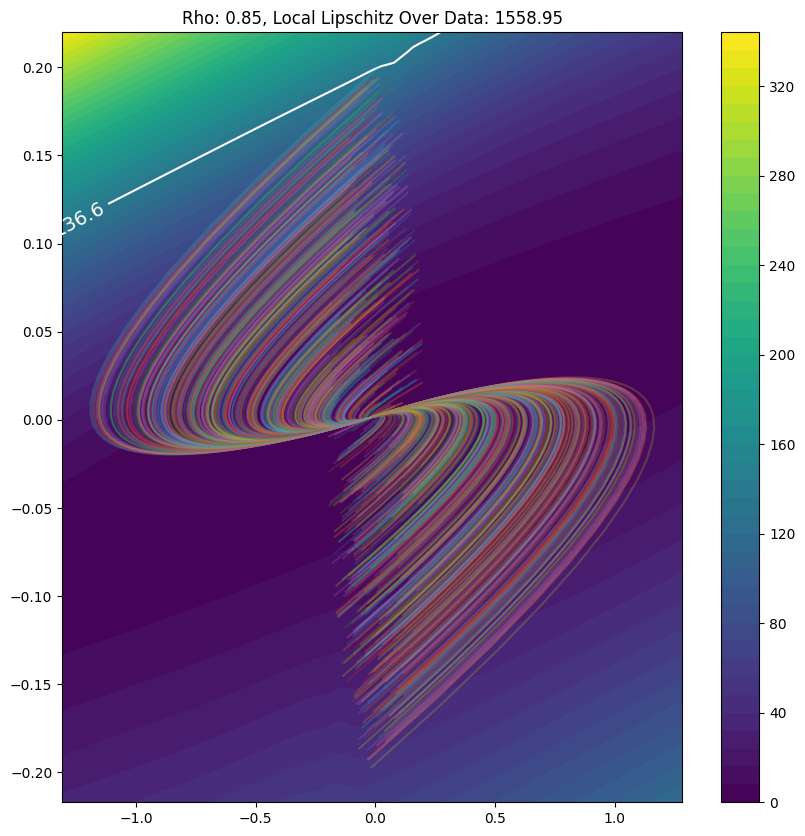

torch.Size([225000])


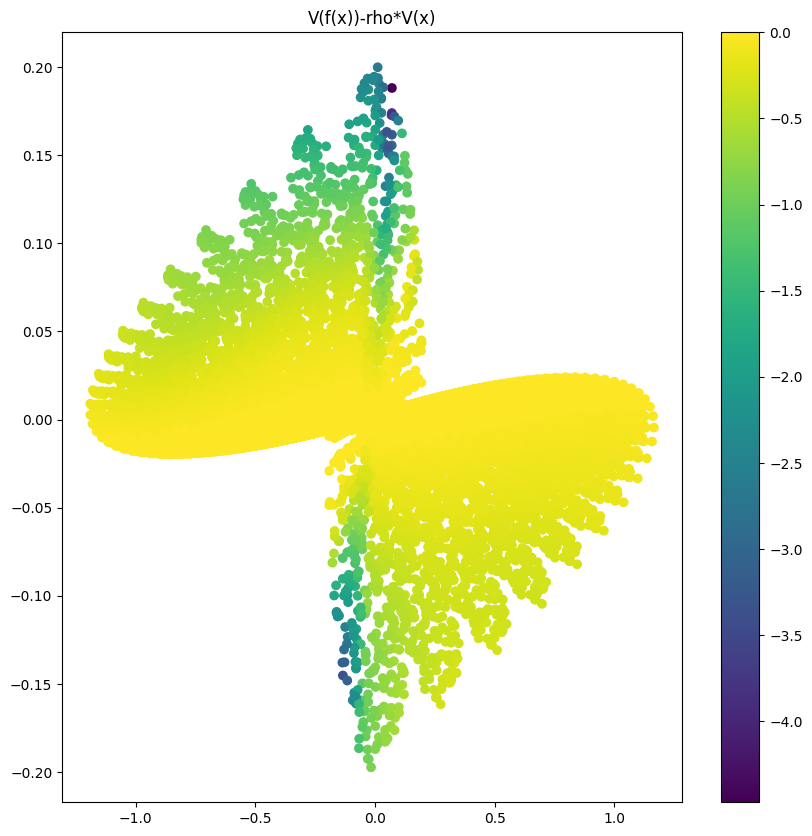

In [89]:
###############################
### Learn Lyapunov Function ###
###############################

from controls import mlp_lyapunov, mlp_lyapunov_reparam
from experiments import load_experiment
from theorem_tools import plot_violation, plot_figure

z_eq = ae.encode(torch.tensor([0.,0.,0.,0]).float())
#z_eq = torch.tensor([0.,0.]).float()
print("z_eq:", z_eq)
rho = 0.85 #0.85 #0.80 #0.75
features = 256
parameterization = "ellipse" #"ellipse"
V, rho, alpha, lip = mlp_lyapunov_reparam(z_data, epochs=int(3e4), lr=2e-4, grid_dens=100, rho=rho, z_eq=z_eq, parameterization=parameterization, features=256) #ep 0.5e4
plot_violation(V, rho, torch.tensor(z_data), ae, lip.item(), gamma_fwd, alpha/6, plot_contours=False)

(103, 4)
110.90742492675781


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


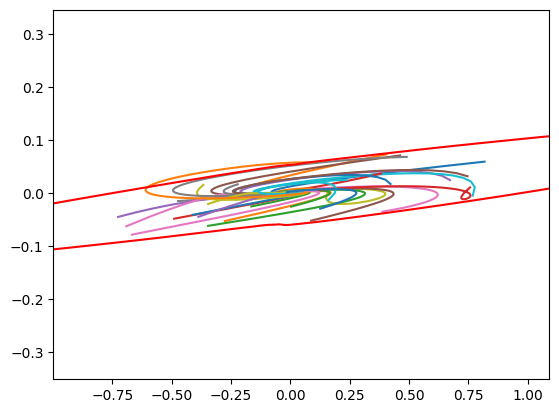

gamma fwd: 0.0151710035
L: 330.1026916503906
a0: 5.545371246337891
rho: 0.85
Ly/p: 33.386593
R: 2.0890350341796875


100%|██████████| 103/103 [00:39<00:00,  2.58it/s]


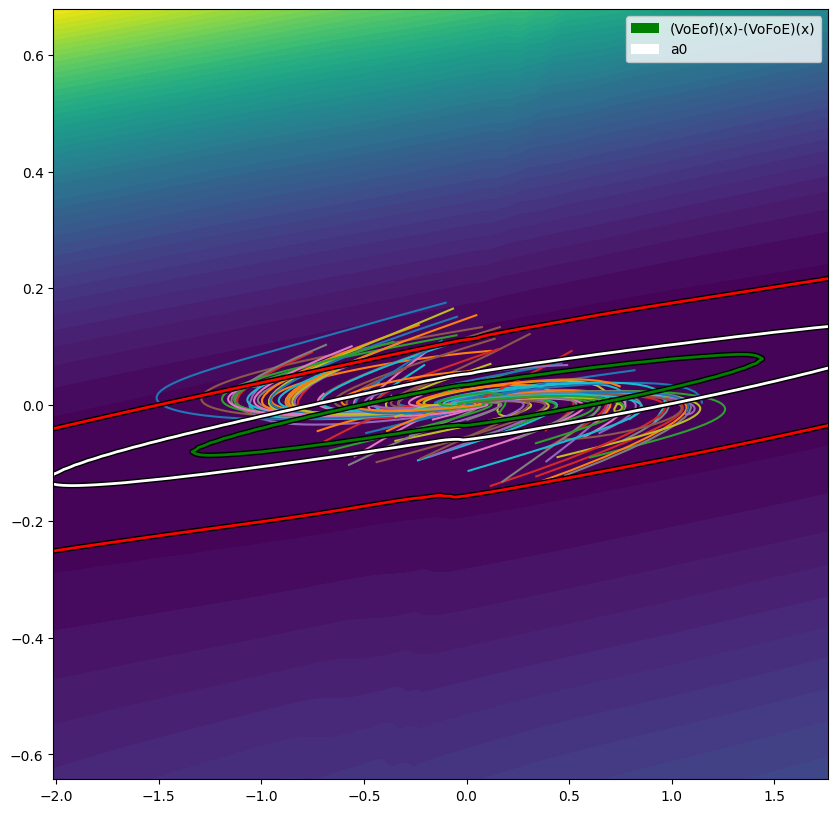

In [92]:
from theorem_tools import compute_preimage, plot_lyapunov_lvlsets

#Dx = compute_preimage(ae, z_data, 0.05, 10, uniform_sampling=True)
#Dx = compute_preimage(ae, z_data, 0.05, 7, uniform_sampling=True) #7
Dx = compute_preimage(ae, z_data, 0.75, 7, uniform_sampling=True) # BEST: 0.25 0.1, 10 
print(Dx.shape)
a0 = torch.max(V(ae.encode(torch.tensor(Dx)))).cpu().item()
print(a0)
Dz = z_data
Dxtraj, gamma, L, res = plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0/20, rho, only_rollout=False, n_per_axis=175) # BEST: a0/6
#plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0)

torch.Size([171000])


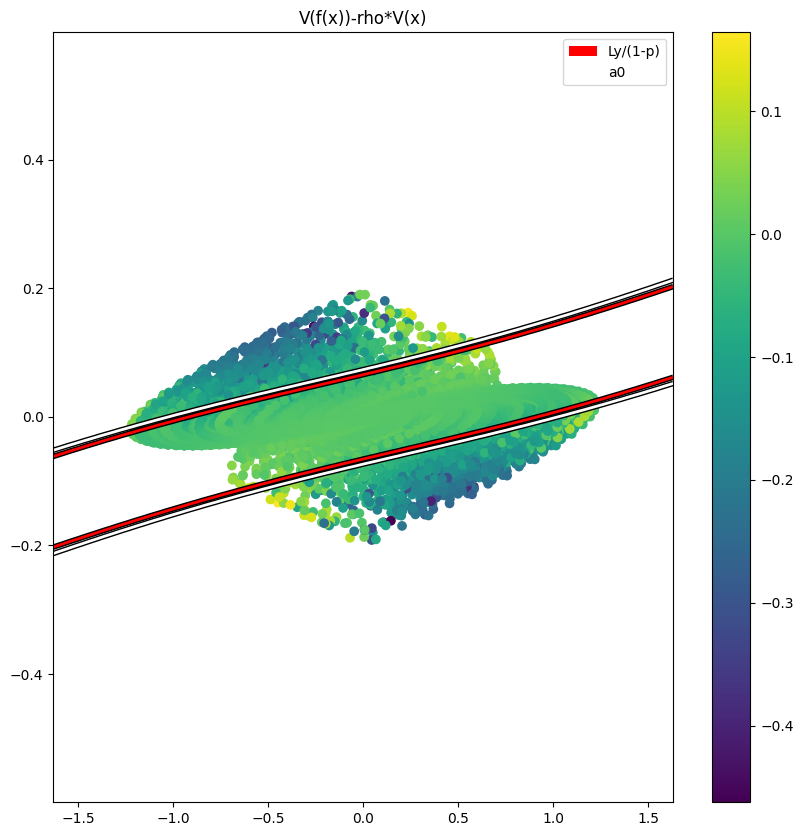

In [15]:
from theorem_tools import plot_violation

plot_violation(V, rho, torch.tensor(Dxtraj), ae, gamma, L, a0/6)

gets into 2
gets into 3
750


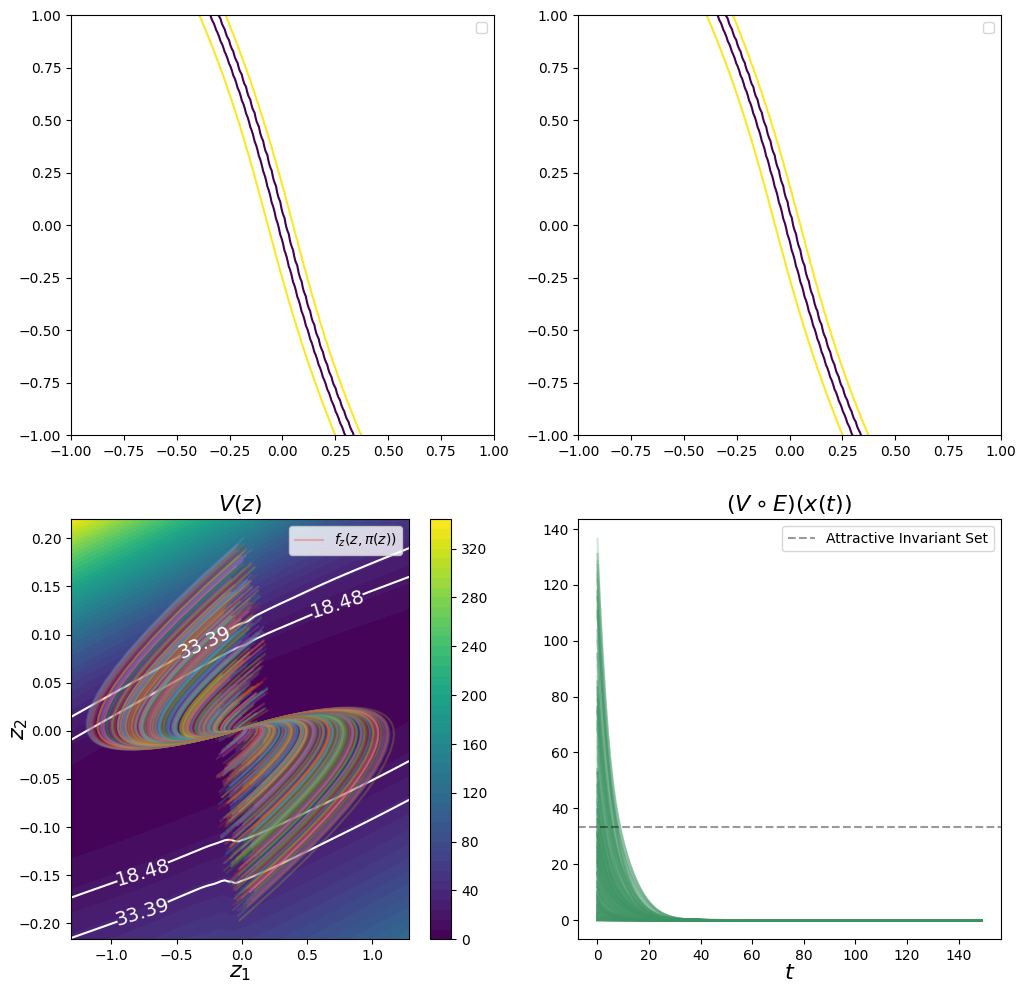

In [93]:
###################
### Make Figure ###
###################


from plotting import plot_lyapunov_slice

lqr = LQR(ae, fdyn)
#plot_lyapunov_slice(V, lqr, ae, (0.5, 0.05), (0.5, 0.05), z_data, z_proj_data)
#plot_lyapunov_slice(V, lqr, ae, (rz_init, rz_init), (rz_init, rz_init), z_data, z_proj_data, 1.13, alpha)
plot_figure(V, lqr, ae, (1., 1.), (1., 1.), z_data, z_proj_data, (L*gamma/(1-rho)).item(), a0/6, res)
#0.001974


In [ ]:
###############################################
### Video: Evolution of Latent Trajectories ###
###############################################
    

from videos import latent_projections_video
from controls import LQR
lqr = LQR(ae, fdyn)
latent_projections_video(lqr, ae, fdyn, 0.2, T=500, N=9)